# SFRN Ensemble

In [1]:
import time

import numpy as np
import spectral
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
 
from Utils import zca, loadData, createImageCubes, count_FLOPs

In [2]:
dataset = 'IP'
HSI, GT, label_names = loadData(dataset)

seed = 0
bandsNum = 3
train_size = 0.1
patch = 11
epochNum = 50

## Model and Training

In [3]:
trf = zca.ZCA().fit(HSI.reshape(-1, HSI.shape[2]))
HSI_whiten = trf.transform(HSI.reshape(-1, HSI.shape[2])).reshape(HSI.shape)
X, y = createImageCubes(HSI_whiten, GT, windowSize=patch)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size, random_state=seed, stratify=y)
ytrain = keras.utils.to_categorical(ytrain)
y_pred_ensemble = []
y_classify_ensemble = []


for i in range(10):
    IL = keras.Input(shape=(patch, patch, Xtrain.shape[3]), name='IL')
    squeeze = tf.reduce_mean(IL, axis=(1,2), keepdims=True, name='GAP')
    hidden = keras.layers.Dense(units=Xtrain.shape[3]//2, activation='relu', name='Dense1')(squeeze)
    excitation = keras.layers.Dense(units=Xtrain.shape[3], activation='sigmoid', name='Dense2')(hidden)
    refine = tf.multiply(IL, excitation)

    C0 = keras.layers.Conv2D(filters=bandsNum, kernel_size=(1,1), activation='sigmoid', name='C0')(refine)
    C1 = keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='C1')(C0)
    C2 = keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='C2')(C1) 
    FL = keras.layers.Flatten(name='FL')(C2)        
    D1 = keras.layers.Dense(units=64, activation='relu', name='D1')(FL)
    OL = keras.layers.Dense(units=ytrain.shape[1], activation='softmax', name='OL')(D1)
    model = keras.models.Model(inputs=IL, outputs=OL, name='SRF-CNN')

    adam = keras.optimizers.Adam(lr=0.001, decay=1e-06)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    model.fit(x=Xtrain, y=ytrain, batch_size=16, epochs=epochNum, verbose=0)

    y_1ok = model.predict(Xtest)
    y_pred = np.argmax(y_1ok, axis=1)
    oa = accuracy_score(ytest, y_pred)
    print(f'Individual Classification #{i+1}   Overall accuracy: {oa*100:.2f}%')

    y_pred_ensemble.append(y_1ok)
    y_classify = model.predict(X)
    y_classify_ensemble.append(y_classify)


y_pred = np.argmax(sum(y_pred_ensemble), axis=1)
oa = accuracy_score(ytest, y_pred)
print(f'\nOverall accuracy: {oa*100:.2f}%')

Individual Classification #1   Overall accuracy: 98.93%
Individual Classification #2   Overall accuracy: 98.34%
Individual Classification #3   Overall accuracy: 98.53%
Individual Classification #4   Overall accuracy: 98.17%
Individual Classification #5   Overall accuracy: 98.44%
Individual Classification #6   Overall accuracy: 98.53%
Individual Classification #7   Overall accuracy: 98.36%
Individual Classification #8   Overall accuracy: 98.81%
Individual Classification #9   Overall accuracy: 99.02%
Individual Classification #10   Overall accuracy: 98.70%

Overall accuracy: 99.64%


In [4]:
model.summary()
print(f'Cube size: {patch}x{patch}x{bandsNum}   FLOPs: {format(count_FLOPs(model))}')
keras.utils.plot_model(model, 'model_srfcnn.png', show_shapes=True, dpi=64)

Model: "SRF-CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
IL (InputLayer)                 [(None, 11, 11, 144) 0                                            
__________________________________________________________________________________________________
tf_op_layer_GAP_9 (TensorFlowOp [(None, 1, 1, 144)]  0           IL[0][0]                         
__________________________________________________________________________________________________
Dense1 (Dense)                  (None, 1, 1, 72)     10440       tf_op_layer_GAP_9[0][0]          
__________________________________________________________________________________________________
Dense2 (Dense)                  (None, 1, 1, 144)    10512       Dense1[0][0]                     
____________________________________________________________________________________________

## Evaluation

In [4]:
report = classification_report(ytest, y_pred, target_names=label_names, digits=4)
confusion = confusion_matrix(ytest, y_pred)
aa = np.mean(np.nan_to_num(np.diag(confusion)/np.sum(confusion, axis=1)))
oa = accuracy_score(ytest, y_pred)
kappa = cohen_kappa_score(ytest, y_pred)

print(f'Dataset: {dataset}   Training samples: {100*train_size:.0f}%  Cube size: {patch}x{patch}x{bandsNum}   Epochs: {epochNum}')
print(f'Parameters: {model.summary(print_details = False)}   Overall accuracy: {oa*100:.2f}%   Average accuracy: {aa*100:.2f}%    Kappa: {kappa}\n')
#print(confusion)
print(report)

Dataset: KSC   Training samples: 10%  Cube size: 11x11x3   Epochs: 50
Parameters: (272104, 0)   Overall accuracy: 99.64%   Average accuracy: 99.16%    Kappa: 0.9959642826103605

                 precision    recall  f1-score   support

          Scrub     1.0000    1.0000    1.0000       685
   Willow swamp     1.0000    1.0000    1.0000       219
     CP hammock     1.0000    0.9870    0.9934       230
     Slash pine     0.9303    1.0000    0.9639       227
  Oak/Broadleaf     1.0000    0.9034    0.9493       145
       Hardwood     1.0000    1.0000    1.0000       206
          Swamp     1.0000    1.0000    1.0000        94
Gramionoi marsh     1.0000    1.0000    1.0000       388
 Spartina marsh     1.0000    1.0000    1.0000       468
  Cattail marsh     1.0000    1.0000    1.0000       364
     Salt marsh     1.0000    1.0000    1.0000       377
      Mud flats     1.0000    1.0000    1.0000       453
          Water     1.0000    1.0000    1.0000       834

       accuracy       

## Visualization

In [5]:
y_classify = np.argmax(sum(y_classify_ensemble), axis=1)+1

outputs = np.zeros(GT.shape)
k=0
for i in range(GT.shape[0]):
    for j in range(GT.shape[1]):
        if int(GT[i,j]) == 0 :
            continue
        else:
            outputs[i, j] = y_classify[k]
            k += 1

C:\Users\hevig\miniconda3\envs\envTF\lib\site-packages\spectral\graphics\spypylab.py:27: MatplotlibDeprecationWarning: 
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  mpl.rcParams['keymap.all_axes'] = ''
C:\Users\hevig\miniconda3\envs\envTF\lib\site-packages\spectral\graphics\spypylab.py:905: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  self.class_axes = plt.imshow(self.class_rgb, **kwargs)


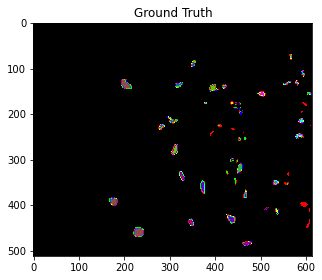

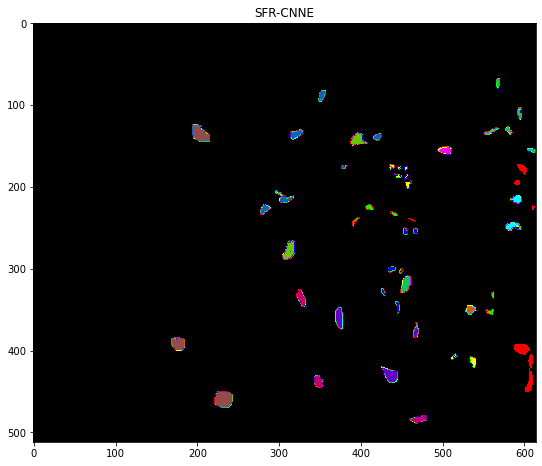

In [6]:
ground_truth = spectral.imshow(classes = GT,figsize =(5,5), title='Ground Truth')
spectral.save_rgb(str(dataset)+"_ground_truth.png", GT, colors=spectral.spy_colors)
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(9,9), title='SFR-CNNE')
spectral.save_rgb(str(dataset)+"_srfcnne"+".png", outputs.astype(int), colors=spectral.spy_colors)